In [1]:
# langgraph_pipeline.py (Refactored with routing, structured output, and conditional agent)

import streamlit as st
import json
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

from general_doc_parser import parse_documents_together
from utils import (
    query_bedrock_with_multiple_pdfs,
    try_parse_json_like,
    render_json_output,
    render_json_checklist,
)
from prompts import PO_prompt, sspr_prompt, checklist_prompt
from model_registry import ModelRegistry

# -------------------------------
# Pydantic Schemas for Structured Output
# -------------------------------
class MatchResult(BaseModel):
    match: str = Field(..., pattern="^(Yes|No|Mostly Yes)$")
    PO: str
    source_1: str = ""
    source_2: str = ""

class ChecklistItem(BaseModel):
    check: str
    status: str = Field(..., pattern="^(✅ Passed|❌ Missing|🟡 Exception|❓ Uncertain)$")
    note: str

class CombinedResult(BaseModel):
    data_validation: Dict[str, MatchResult]
    compliance_checklist: List[ChecklistItem]
    data_security_flag: bool = False  # Optional future usage

# -------------------------------
# State Schema
# -------------------------------
class PipelineState(TypedDict):
    uploaded_files: List[Any]
    parsed_data: Dict[str, Any]
    model_output: Dict[str, Any]
    raw_output: str
    needs_data_security: bool

# -------------------------------
# Agents / Nodes
# -------------------------------

def parse_documents(state: PipelineState) -> Dict[str, Any]:
    uploaded_files = state["uploaded_files"]
    parsed = parse_documents_together(uploaded_files)

    # Heuristic check for software/data in docs to trigger security agent
    parsed_str = json.dumps(parsed).lower()
    keywords = ["data", "cloud", "software", "platform", "dashboard", "api"]
    needs_data_security = any(k in parsed_str for k in keywords)

    return {"parsed_data": parsed, "needs_data_security": needs_data_security}

def determine_prompt_routing(parsed: Dict[str, Any]) -> str:
    doc_types = {doc.get("Document Type", "").lower() for doc in parsed.values()}
    if "purchase order" in doc_types:
        return PO_prompt
    elif "sspr" in doc_types:
        return sspr_prompt
    else:
        return checklist_prompt

def validate_with_enforced_schema(state: PipelineState) -> Dict[str, Any]:
    parsed = state["parsed_data"]
    prompt_template = determine_prompt_routing(parsed)
    doc_text = json.dumps(parsed, indent=2)

    prompt = PromptTemplate.from_template(prompt_template)
    parser = PydanticOutputParser(pydantic_object=CombinedResult)
    full_prompt = prompt.format(doc_text=doc_text) + "\n\n" + parser.get_format_instructions()

    try:
        model_id = ModelRegistry.sonnet_3_5
        response_text = query_bedrock_with_multiple_pdfs(full_prompt, [], model_id=model_id)
    except Exception:
        fallback_model = ModelRegistry.haiku_3_5
        response_text = query_bedrock_with_multiple_pdfs(full_prompt, [], model_id=fallback_model)

    try:
        parsed_response = parser.parse(response_text)
    except Exception:
        parsed_response = try_parse_json_like(response_text)

    return {
        "model_output": parsed_response,
        "raw_output": response_text
    }

def data_security_agent(state: PipelineState) -> Dict[str, Any]:
    st.subheader("🔒 Data Security Agent Triggered")
    st.info("This purchase may involve software or data. Please ensure Appendix DS is attached.")
    return {}

def display_results(state: PipelineState) -> Dict[str, Any]:
    parsed = state.get("model_output", {})
    if not parsed:
        st.error("❌ Failed to parse model output as JSON")
        return {}

    if "data_validation" in parsed:
        st.subheader("✅ Data Validation Results")
        render_json_output(parsed["data_validation"])

    if "compliance_checklist" in parsed:
        st.subheader("✅ Checklist Results")
        render_json_checklist(parsed["compliance_checklist"])

    return {}

# -------------------------------
# LangGraph Definition
# -------------------------------
graph = StateGraph(PipelineState)
graph.add_node("parse_documents", RunnableLambda(parse_documents))
graph.add_node("run_validation", RunnableLambda(validate_with_enforced_schema))
graph.add_node("data_security_check", RunnableLambda(data_security_agent))
graph.add_node("display_results", RunnableLambda(display_results))

graph.set_entry_point("parse_documents")
graph.add_edge("parse_documents", "run_validation")
graph.add_conditional_edges("run_validation", lambda state: {
    "data_security_check" if state.get("needs_data_security") else "display_results"
})
graph.add_edge("data_security_check", "display_results")
graph.add_edge("display_results", END)

app = graph.compile()

# -------------------------------
# Streamlit Integration
# -------------------------------
def main():
    st.set_page_config(page_title="LangGraph - Checklist + Validator")
    st.title("📁 LangGraph Procurement Validator")

    uploaded_files = st.file_uploader("Upload your PDF documents", type=["pdf"], accept_multiple_files=True)

    if uploaded_files and st.button("Run LangGraph Validation"):
        app.invoke({"uploaded_files": uploaded_files})

if __name__ == "__main__":
    main()

2025-05-05 12:52:51.820 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:52:51.821 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:52:51.904 
  command:

    streamlit run /Users/belalelshenety/Documents/GitHub/DxHub/university-buyerreview/Langraph_MAS/.venv/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-05-05 12:52:51.904 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:52:51.904 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:52:51.905 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:52:51.905 Thread 'Mai

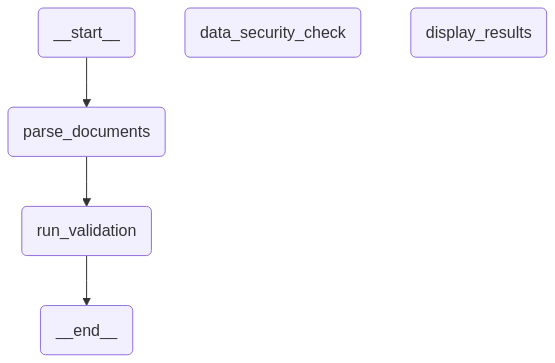

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [4]:
# langgraph_pipeline.py

from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import HumanMessage
import streamlit as st
import json

from general_doc_parser import parse_documents_together
from utils import (
    query_bedrock_with_multiple_pdfs,
    try_parse_json_like,
    render_json_output,
    render_json_checklist,
)
from prompts import checklist_and_validation_prompt
from model_registry import ModelRegistry
from typing import TypedDict, List, Dict, Any

class PipelineState(TypedDict):
    uploaded_files: List[Any]
    parsed_data: Dict[str, Any]
    model_output: Dict[str, Any]
    raw_output: str


# State structure:
# {
#   "uploaded_files": [...],
#   "parsed_data": {...},
#   "model_output": {...}
# }

def parse_documents(state):
    uploaded_files = state["uploaded_files"]
    parsed = parse_documents_together(uploaded_files)
    return {"parsed_data": parsed}

def validate_and_check(state):
    parsed = state["parsed_data"]
    doc_text = parsed if isinstance(parsed, str) else json.dumps(parsed, indent=2)
    prompt = checklist_and_validation_prompt.format(doc_text=doc_text)
    response_text = query_bedrock_with_multiple_pdfs(prompt, [], model_id=ModelRegistry.sonnet_3_7)
    parsed_response = try_parse_json_like(response_text)
    return {"model_output": parsed_response, "raw_output": response_text}

def display_results(state):
    parsed = state.get("model_output", {})
    if not parsed:
        st.error("❌ Failed to parse model output as JSON")
        return
    if "data_validation" in parsed:
        st.subheader("✅ Data Validation Results")
        render_json_output(parsed["data_validation"])
    if "compliance_checklist" in parsed:
        st.subheader("✅ Checklist Results")
        render_json_checklist(parsed["compliance_checklist"])
    return {}

# LangGraph definition
graph = StateGraph(PipelineState)
graph.add_node("parse_documents", RunnableLambda(parse_documents))
graph.add_node("validate_and_check", RunnableLambda(validate_and_check))
graph.add_node("display_results", RunnableLambda(display_results))

graph.set_entry_point("parse_documents")
graph.add_edge("parse_documents", "validate_and_check")
graph.add_edge("validate_and_check", "display_results")
graph.add_edge("display_results", END)

app = graph.compile()

# Streamlit integration
def main():
    st.set_page_config(page_title="LangGraph - Checklist + Validator")
    st.title("📁 LangGraph Procurement Validator")

    uploaded_files = st.file_uploader("Upload your PDF documents", type=["pdf"], accept_multiple_files=True)

    if uploaded_files and st.button("Run LangGraph Validation"):
        app.invoke({"uploaded_files": uploaded_files})

if __name__ == "__main__":
    main()

2025-05-05 12:55:28.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:28.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:28.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:28.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:28.206 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:28.206 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:28.207 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 12:55:28.207 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

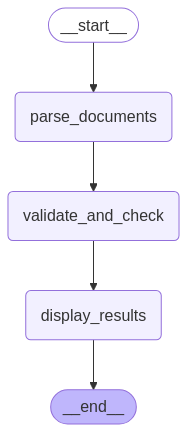

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)